In [4]:
import torch

import transformers
from transformers import ViTForImageClassification


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

/home/hice1/bgoyal7/.conda/envs/vitinf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [9]:
from transformers import ViTImageProcessor
from PIL import Image
i1 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp1_equal_area_circles/1/1_1.png').convert("RGB")
i2 = Image.open('/home/hice1/bgoyal7/scratch/HML/experiment_data/exp1_equal_area_circles/1/1_2.png').convert("RGB")
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# ls = [i1 for _ in range(2)]
tempinputs = processor(images=i1, return_tensors="pt").to(device).pixel_values
with torch.no_grad(): 
    cur_outputs = model(tempinputs, output_attentions = True, output_hidden_states = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


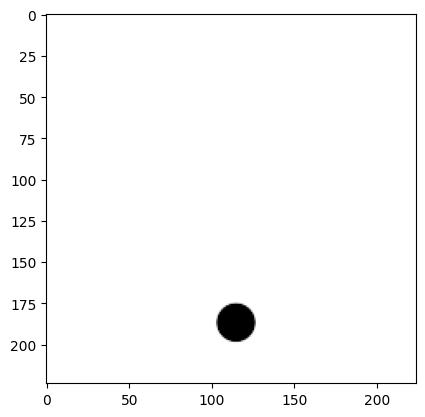

In [10]:
import matplotlib.pyplot as plt
plt.imshow(tempinputs.cpu().squeeze().permute(1, 2, 0))

In [11]:

prediction = cur_outputs.logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: puck, hockey puck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


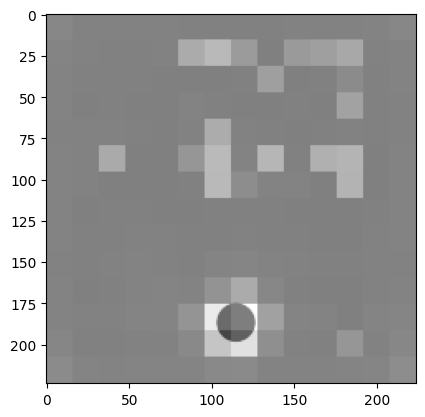

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Display the first image
ax.imshow(tempinputs.cpu().squeeze().permute(1, 2, 0))

# Overlay the second image with transparency
ax.imshow(img.squeeze(), alpha=0.5, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


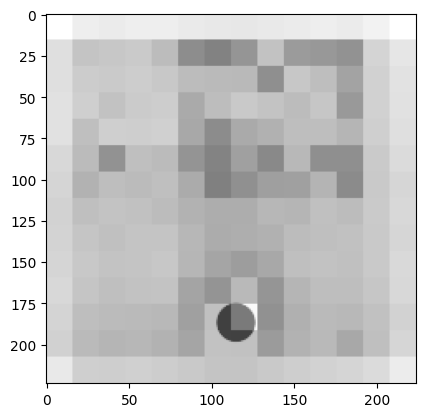

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Load the two images

# Create a figure and axes
fig, ax = plt.subplots()

# Display the first image
ax.imshow(pixel_values.cpu().squeeze().permute(1, 2, 0))

# Overlay the second image with transparency
ax.imshow(imversion, alpha=0.5, cmap='gray')

# Save the overlaid image to a PNG file
plt.savefig('sample.png')


In [4]:
import os
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
curdir = '/home/hice1/bgoyal7/scratch/HML/ViT_embedding/exp1_equal_area_circles'
def calculate_cosine_similarity(a_array, b_array):
    similarity_matrix = cosine_similarity(a_array, b_array)
    return np.sum(similarity_matrix)/400
cosinedists  = {}
for i in os.listdir(curdir): 
    a = torch.load(os.path.join(curdir, i), map_location=torch.device('cpu'))
    for j in os.listdir(curdir): 
        b = torch.load(os.path.join(curdir, j), map_location=torch.device('cpu'))
        cosinedists[(int(i.split('.')[0]), int(j.split('.')[0]))] = calculate_cosine_similarity(a[-1][:, 0, :], b[-1][:, 0, :])

{0: [0.9744304656982422, 0.9739532470703125, 0.9818204498291015, 0.9695574188232422, 0.9980867767333984, 0.9820356750488282, 0.9711458587646484, 0.9708882141113281, 0.9750895690917969], 2: [0.9653692626953125, 0.953978271484375, 0.9653692626953125, 0.9657798767089844, 0.9238439178466797, 0.96373046875, 0.9657798767089844, 0.9238438415527344, 0.953978271484375, 0.7705634307861328, 0.96373046875, 0.9687094116210937, 0.7705635070800781, 0.9687094116210937], 1: [0.9744799041748047, 0.9684142303466797, 0.9703653717041015, 0.9728125, 0.9744798278808594, 0.9712553405761719, 0.970221939086914, 0.9630133056640625, 0.8660621643066406, 0.9712553405761719, 0.9630133056640625, 0.968414306640625, 0.9703653717041015, 0.8660621643066406, 0.9728125, 0.970221939086914], 4: [0.9479388427734375, 0.6830596923828125, 0.9265718078613281, 0.9498635101318359, 0.9479388427734375, 0.8751173400878907, 0.9265718078613281, 0.8751173400878907, 0.6830596923828125, 0.9498635101318359], 3: [0.8961759948730469, 0.959607

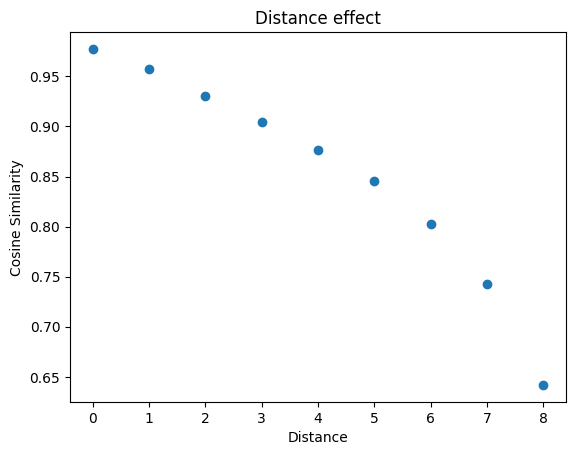

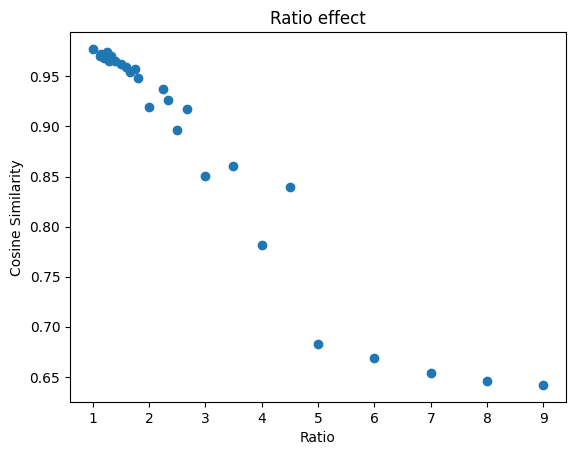

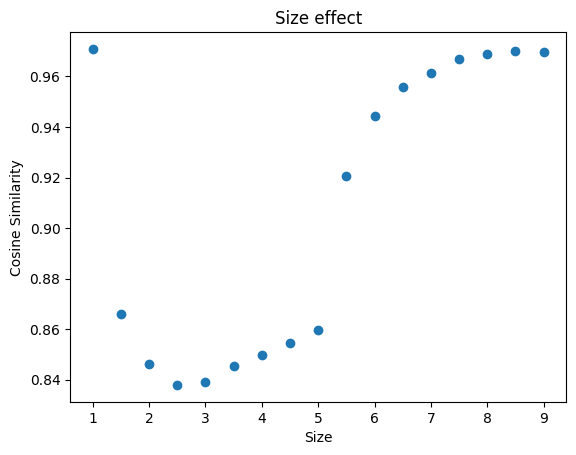

In [13]:
import matplotlib.pyplot as plt
bydist = {}
byratio = {}
bysize = {}
def insert_into_dict(d, key, val):
    if key not in d: 
        d[key] = []
    d[key].append(val)
for (i, val) in cosinedists.items(): 
    insert_into_dict(byratio, max(i[0],i[1])/min(i[0],i[1]), val)
    insert_into_dict(bydist, abs(i[0] - i[1]), val)
    insert_into_dict(bysize, (i[0] + i[1])/2, val)
print(bydist)
print(byratio)
print(bysize)

def plot_for_dict(d, xlabel): 
    x, y = [], []
    for (i, val) in d.items():
        x.append(i)
        y.append(np.mean(val))
    fig, ax = plt.subplots()
    print(x)
    print(y)
    ax.scatter(x, y)
    ax.set_title(xlabel + ' effect')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Cosine Similarity')
plot_for_dict(bydist, 'Distance')
plot_for_dict(byratio, 'Ratio')
plot_for_dict(bysize, 'Size')
